#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=7729364e-1bdd-43e2-88bc-52acb4d4523a
To: /Users/djay/Desktop/master/brain like/part 1/IT_data.h5
100%|████████████████████████████████████████| 384M/384M [02:06<00:00, 3.04MB/s]


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


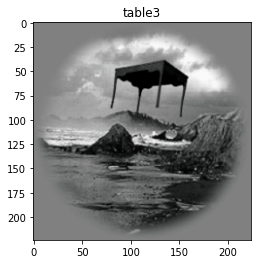

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

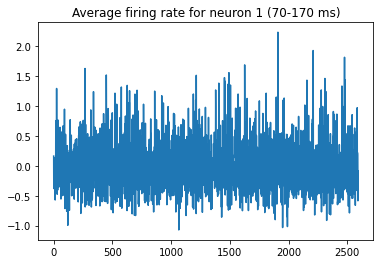

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 0: import packtages and explore data

In [7]:
from sklearn import linear_model
from sklearn import metrics as ms
from sklearn import decomposition
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_10940/2212909228.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [8]:
stimulus_train.shape

(2592, 3, 224, 224)

In [9]:
stimulus_test.shape

(320, 3, 224, 224)

In [10]:
stimulus_val.shape

(288, 3, 224, 224)

In [11]:
spikes_train.shape

(2592, 168)

In [12]:
spikes_val.shape

(288, 168)

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [13]:
X_train = stimulus_train.reshape(2592, 3*224*224) 
y_train = spikes_train
X_val = stimulus_val.reshape(288, 3*224*224) 
y_val = spikes_val

In [14]:
ridge = linear_model.Ridge()
ridge.fit(X_train,y_train)
#ridge.coef_
#ridge.intercept_

/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.98196e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Ridge()

In [15]:
y_pred_ridge = ridge.predict(X_val)
#y_pred_ridge.shape

In [16]:
linear = linear_model.LinearRegression()
linear.fit(X_train,y_train)
#linear.coef_
#linear.intercept_

LinearRegression()

In [17]:
y_pred_linear = linear.predict(X_val)
#y_pred_linear.shape

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

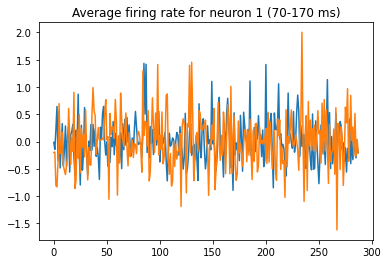

In [18]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
plt.plot(y_pred_ridge[:,neuron_idx])

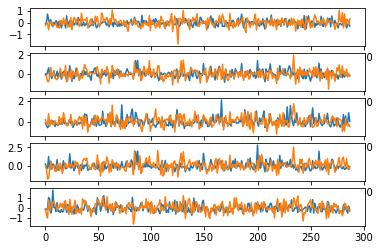

In [19]:
N = 5
fig, axs = plt.subplots(N, 1)

for n in range(N) : 
    axs[n].plot(y_val[:,n])
    axs[n].plot(y_pred_ridge[:,n])

plt.show()

In [20]:
correlation_ridge = []
var_ridge = []
correlation_linear = []
var_linear = []
correlation = []
var = []

for i in range(y_val.shape[1]) : #each neuron
    correlation_ridge.append(pearsonr(y_val[:,i],y_pred_ridge[:,i])[0])
    var_ridge.append(ms.explained_variance_score(y_val[:,i],y_pred_ridge[:,i]))
    
    correlation_linear.append(pearsonr(y_val[:,i],y_pred_linear[:,i])[0])
    var_linear.append(ms.explained_variance_score(y_val[:,i],y_pred_linear[:,i]))
    
    correlation.append(pearsonr(y_pred_ridge[:,i],y_pred_linear[:,i])[0])
    var.append(ms.explained_variance_score(y_pred_ridge[:,i],y_pred_linear[:,i]))

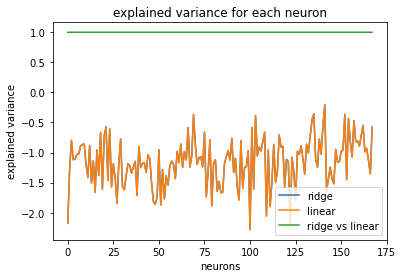

In [21]:
plt.figure()
plt.title('explained variance for each neuron')
plt.xlabel('neurons')
plt.ylabel("explained variance")

plt.plot(var_ridge)
plt.plot(var_linear)
plt.plot(var)
plt.legend(["ridge","linear","ridge vs linear"])

plt.show()

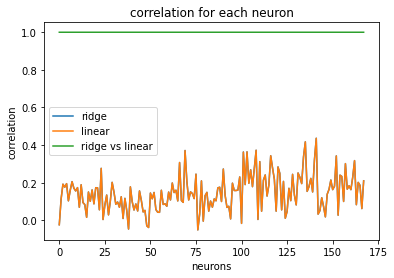

In [22]:
plt.figure()
plt.title('correlation for each neuron')
plt.xlabel('neurons')
plt.ylabel("correlation")

plt.plot(correlation_ridge)
plt.plot(correlation_linear)
plt.plot(correlation)
plt.legend(["ridge","linear","ridge vs linear"])

plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [23]:
pca = PCA(n_components=1000)

In [24]:
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

In [25]:
PCA_ridge = linear_model.Ridge()
PCA_ridge.fit(X_train_recovered,y_train)

/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ridge()

In [26]:
y_pred_pcaridge = PCA_ridge.predict(X_val)

In [27]:
correlation = []
var = []

for i in range(y_val.shape[1]) : #each neuron
    correlation.append(pearsonr(y_pred_pcaridge[:,i],y_val[:,i])[0])
    var.append(ms.explained_variance_score(y_pred_pcaridge[:,i],y_val[:,i]))

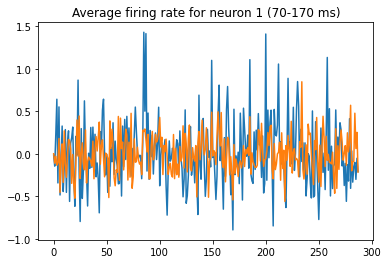

In [28]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
#plt.plot(y_pred_ridge[:,neuron_idx])
plt.plot(y_pred_pcaridge[:,neuron_idx])

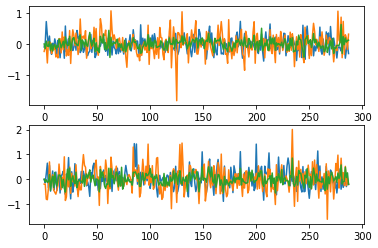

In [29]:
N = 2
fig, axs = plt.subplots(N, 1)

for n in range(N) : 
    axs[n].plot(y_val[:,n])
    axs[n].plot(y_pred_ridge[:,n])
    axs[n].plot(y_pred_pcaridge[:,n])

plt.show()

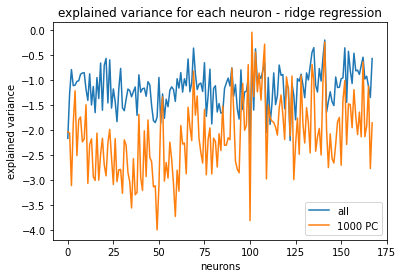

In [30]:
plt.figure()
plt.title('explained variance for each neuron - ridge regression')
plt.xlabel('neurons')
plt.ylabel("explained variance")
plt.plot(var_ridge)
plt.plot(var)
plt.legend(["all","1000 PC"])

plt.show()

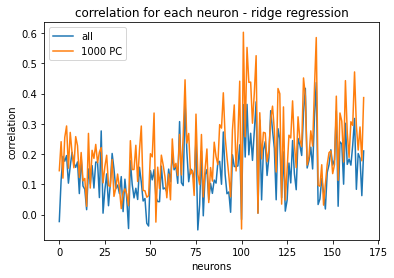

In [31]:
plt.figure()
plt.title('correlation for each neuron - ridge regression')
plt.xlabel('neurons')
plt.ylabel("correlation")
plt.plot(correlation_ridge)
plt.plot(correlation)
plt.legend(["all","1000 PC"])

plt.show()

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [33]:
#### Here your code
#rf = RandomForestClassifier()

alpha_set = [int(x) for x in np.linspace(0.8, 1.2, num = 4)]

param_grid = {'alpha': alpha_set}
# Instantiate the grid search model
grid_search_ridge = GridSearchCV(estimator = ridge, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/djay/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/djay/miniforg

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0, 0, 1, 1]}, verbose=2)

In [34]:
opt_alpha = grid_search_ridge.best_params_
best_grid = grid_search_ridge.best_estimator_
scores = grid_search_ridge.cv_results_["mean_test_score"]
scores_std = grid_search_ridge.cv_results_["std_test_score"]
print("Validations scores are ", scores, "with best score = ", scores.max(), "alpha_opt = ", opt_alpha)

Validations scores are  [-1.35786275 -1.35786275 -1.11641017 -1.11641017] with best score =  -1.1164101684797139 alpha_opt =  {'alpha': 1}


In [35]:
predict_spike_cv = grid_search_ridge.predict(X_val)

In [36]:
predict_spike_cv.shape

(288, 168)

In [37]:
correlation_CV = []
var_CV = []

for i in range(y_val.shape[1]) : #each neuron
    correlation_CV.append(pearsonr(predict_spike_cv[:,i],y_val[:,i])[0])
    var_CV.append(ms.explained_variance_score(predict_spike_cv[:,i],y_val[:,i]))

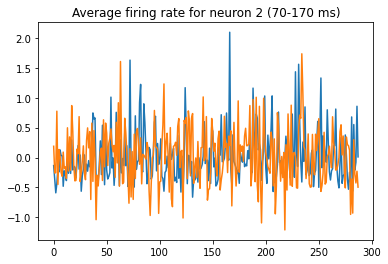

In [38]:
neuron_idx = 2

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
plt.plot(predict_spike_cv[:,neuron_idx])

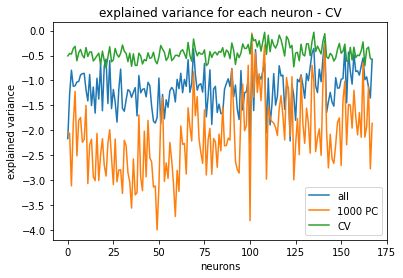

In [39]:
plt.figure()
plt.title('explained variance for each neuron - CV')
plt.xlabel('neurons')
plt.ylabel("explained variance")
plt.plot(var_ridge)
plt.plot(var)
plt.plot(var_CV)
plt.legend(["all","1000 PC", "CV"])

plt.show()

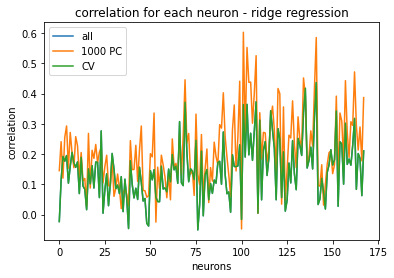

In [40]:
plt.figure()
plt.title('correlation for each neuron - ridge regression')
plt.xlabel('neurons')
plt.ylabel("correlation")
plt.plot(correlation_ridge)
plt.plot(correlation)
plt.plot(correlation_CV)
plt.legend(["all","1000 PC", "CV"])

plt.show()